# Factor trading - Policy gradient

Optimise the return of the portfolio by learning the policy from the factor database

NEED TO IMPLEMENT THE REWARD FUNCTION

## 1. load the libraries and constants

In [13]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

SOURCE_FOLDER = 'Data-processed'
FACTOR_FOLDER = 'Data-factor'
TARGET_FOLDER = "Output"

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"
RISK_FILE = "data_risk.csv"
FACTOR_FILE = "data_factor.csv"

INVESTMENT = 10000
TRANSACTION_COSTS = 0.001  # 0.1% percent transaction costs 

## 2. load the data

In [4]:
# Load the time-series dataset, the static dataset and the risk dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)
df_risk = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, RISK_FILE),encoding='utf-8', index_col=0)
# Load the factor dataset
df_factor = pd.read_csv(os.path.join(os.getcwd(),FACTOR_FOLDER, FACTOR_FILE),encoding='utf-8', index_col=0)

## 3. Factor trading

Train the policy with a Neural Network using first the closing price of the stock and then the factors signals that have been calculated. 

The structure of the network is as follows:
* 256 activations units with ReLu
* Softmax output layer with 3 activations. = buy/sell/hold. 
* Put the rewards. 

get the information about the construction of the rewards/ 

In [34]:
#df_data["-".join(['US22160K1051',"P"])].dropna().values.tolist()  # Modification to feed the NN.

In [35]:
name = 'Policy Gradient agent'
class Agent:
    """
    Definition of the class Agent. 
    Policy trained from the closing price "-P" or from the factors vector.
    Action are buy +1, sell -1, keep position  = 0
    """
    LEARNING_RATE = 1e-4  # lr
    LAYER_SIZE = 256  # Number of hidden units in the Neural Network
    GAMMA = 0.9  # Discount Rate for the reward
    OUTPUT_SIZE = 3  # Output of the policy buy,sell,keep. (Case of one stock)

    def __init__(self, state_size, window_size, trend, skip):
        """
        Constructor. 
        """
        self.state_size = state_size  #
        self.window_size = window_size  # Nb of history taken to predict the policy
        self.half_window = window_size // 2  #
        self.trend = trend  # values to feed the placeholder. 
        self.skip = skip
        
        # Description of the variables of the network
        self.X = tf.placeholder(tf.float32, (None, self.state_size))  # input - closing price of Factors
        self.REWARDS = tf.placeholder(tf.float32, (None)) # History of the rewards generated from the NN
        self.ACTIONS = tf.placeholder(tf.int32, (None))  # History of the actions produced by NN
        
        # Description of the Network structure. 
        feed_forward = tf.layers.dense(self.X,
                                       self.LAYER_SIZE,
                                       activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward,
                                      self.OUTPUT_SIZE,
                                      activation = tf.nn.softmax)  # Probability of action
        input_y = tf.one_hot(self.ACTIONS,
                             self.OUTPUT_SIZE) 
        loglike = tf.log(
            (input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(
            tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        """
        Generate new policy result - buy/sell/keep for a stock
        """
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        """
        
        """
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        """
        
        """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        """
        
        """
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        """
        
        """
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return {"buy": states_buy,
            "sell": states_sell,
            "gains": total_gains,
            "invest":invest}
#         return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        """
        """
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [36]:
#close = df.Close.values.tolist()
close = df_data["-".join(['US22160K1051',"P"])].dropna().values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 80, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 4045.961100.3, cost: -4601.156738, total money: 107.141100
epoch: 20, total rewards: 5020.561100.3, cost: -5644.921875, total money: 129.284200
epoch: 30, total rewards: 6113.616100.3, cost: -7671.921387, total money: 456.354200
epoch: 40, total rewards: 7313.649200.3, cost: -10686.560547, total money: 690.407300
epoch: 50, total rewards: 3728.584800.3, cost: -24653.158203, total money: 4927.784800
epoch: 60, total rewards: 304.998800.3, cost: -30993.697266, total money: 10304.998800
epoch: 70, total rewards: 1538.986400.3, cost: -28637.201172, total money: 8093.156400
epoch: 80, total rewards: 1566.328500.3, cost: -29512.998047, total money: 8492.478500


In [27]:
#states_buy, states_sell, total_gains, invest 
array = agent.buy(initial_money = initial_money)

day 13: buy 1 unit at price 36.500000, total balance 9963.500000
day 17, sell 1 unit at price 36.080000, investment -1.150685 %, total balance 9999.580000,
day 18: buy 1 unit at price 36.900000, total balance 9962.680000
day 19: buy 1 unit at price 36.940000, total balance 9925.740000
day 22: buy 1 unit at price 37.300000, total balance 9888.440000
day 23, sell 1 unit at price 37.920000, investment 2.764228 %, total balance 9926.360000,
day 26: buy 1 unit at price 39.410000, total balance 9886.950000
day 28, sell 1 unit at price 37.750000, investment 2.192745 %, total balance 9924.700000,
day 29: buy 1 unit at price 37.610000, total balance 9887.090000
day 30: buy 1 unit at price 37.760000, total balance 9849.330000
day 32, sell 1 unit at price 37.480000, investment 0.482574 %, total balance 9886.810000,
day 33, sell 1 unit at price 38.180000, investment -3.121035 %, total balance 9924.990000,
day 35: buy 1 unit at price 38.450000, total balance 9886.540000
day 36, sell 1 unit at price

day 378: buy 1 unit at price 45.320000, total balance 9666.102000
day 379: buy 1 unit at price 45.360000, total balance 9620.742000
day 380, sell 1 unit at price 45.090000, investment -3.281853 %, total balance 9665.832000,
day 382: buy 1 unit at price 45.640000, total balance 9620.192000
day 385: buy 1 unit at price 45.960000, total balance 9574.232000
day 386, sell 1 unit at price 46.450000, investment 1.663384 %, total balance 9620.682000,
day 387: buy 1 unit at price 46.400000, total balance 9574.282000
day 392, sell 1 unit at price 45.920000, investment -1.438077 %, total balance 9620.202000,
day 393, sell 1 unit at price 46.000000, investment -0.776531 %, total balance 9666.202000,
day 395: buy 1 unit at price 46.530000, total balance 9619.672000
day 398, sell 1 unit at price 45.380000, investment -0.022031 %, total balance 9665.052000,
day 399: buy 1 unit at price 44.450000, total balance 9620.602000
day 400, sell 1 unit at price 44.250000, investment -1.513465 %, total balance 

day 650: buy 1 unit at price 52.440000, total balance 9769.787200
day 651, sell 1 unit at price 51.000000, investment -2.968037 %, total balance 9820.787200,
day 652, sell 1 unit at price 51.780000, investment -4.111111 %, total balance 9872.567200,
day 654: buy 1 unit at price 51.660000, total balance 9820.907200
day 655: buy 1 unit at price 50.200000, total balance 9770.707200
day 658, sell 1 unit at price 51.650000, investment -2.103867 %, total balance 9822.357200,
day 660, sell 1 unit at price 51.950000, investment -0.934401 %, total balance 9874.307200,
day 661, sell 1 unit at price 51.850000, investment 0.367789 %, total balance 9926.157200,
day 665, sell 1 unit at price 50.500000, investment 0.597610 %, total balance 9976.657200,
day 666: buy 1 unit at price 49.610000, total balance 9927.047200
day 668, sell 1 unit at price 49.160000, investment -0.907075 %, total balance 9976.207200,
day 669: buy 1 unit at price 49.250000, total balance 9926.957200
day 670: buy 1 unit at price

day 938, sell 1 unit at price 59.380000, investment -2.206851 %, total balance 10010.597100,
day 939: buy 1 unit at price 60.690000, total balance 9949.907100
day 940: buy 1 unit at price 61.120000, total balance 9888.787100
day 942, sell 1 unit at price 61.810000, investment 1.845444 %, total balance 9950.597100,
day 943: buy 1 unit at price 61.620000, total balance 9888.977100
day 946, sell 1 unit at price 63.270000, investment 3.517670 %, total balance 9952.247100,
day 947: buy 1 unit at price 63.710000, total balance 9888.537100
day 948, sell 1 unit at price 63.310100, investment 2.742778 %, total balance 9951.847200,
day 949: buy 1 unit at price 69.130000, total balance 9882.717200
day 951: buy 1 unit at price 68.000000, total balance 9814.717200
day 953, sell 1 unit at price 65.950000, investment 3.515932 %, total balance 9880.667200,
day 954, sell 1 unit at price 66.520000, investment -3.775495 %, total balance 9947.187200,
day 955, sell 1 unit at price 66.530000, investment -2.

day 1195, sell 1 unit at price 64.690000, investment -3.375653 %, total balance 8876.287100,
day 1198: buy 1 unit at price 60.470000, total balance 8815.817100
day 1200, sell 1 unit at price 57.060000, investment -15.013405 %, total balance 8872.877100,
day 1201: buy 1 unit at price 54.400000, total balance 8818.477100
day 1203: buy 1 unit at price 59.520000, total balance 8758.957100
day 1204: buy 1 unit at price 58.410000, total balance 8700.547100
day 1205, sell 1 unit at price 53.610000, investment -18.698817 %, total balance 8754.157100,
day 1206: buy 1 unit at price 57.790000, total balance 8696.367100
day 1207: buy 1 unit at price 57.980000, total balance 8638.387100
day 1211: buy 1 unit at price 52.210000, total balance 8586.177100
day 1212, sell 1 unit at price 50.930000, investment -24.469821 %, total balance 8637.107100,
day 1213: buy 1 unit at price 51.900000, total balance 8585.207100
day 1214: buy 1 unit at price 57.480000, total balance 8527.727100
day 1217, sell 1 unit 

day 1502, sell 1 unit at price 58.430000, investment 2.851611 %, total balance 8018.137100,
day 1503, sell 1 unit at price 59.270000, investment 1.177876 %, total balance 8077.407100,
day 1504: buy 1 unit at price 59.570000, total balance 8017.837100
day 1509, sell 1 unit at price 60.050000, investment 2.825342 %, total balance 8077.887100,
day 1511: buy 1 unit at price 59.410000, total balance 8018.477100
day 1512, sell 1 unit at price 59.230000, investment 2.155916 %, total balance 8077.707100,
day 1513, sell 1 unit at price 60.000000, investment 6.082037 %, total balance 8137.707100,
day 1514: buy 1 unit at price 59.710000, total balance 8077.997100
day 1515, sell 1 unit at price 59.280000, investment 4.938927 %, total balance 8137.277100,
day 1517, sell 1 unit at price 59.030000, investment 3.779887 %, total balance 8196.307100,
day 1518, sell 1 unit at price 59.400000, investment 0.677966 %, total balance 8255.707100,
day 1520, sell 1 unit at price 58.790000, investment 0.272898 %

day 1771, sell 1 unit at price 71.600000, investment 27.424809 %, total balance 8254.844600,
day 1772, sell 1 unit at price 72.510000, investment 23.758321 %, total balance 8327.354600,
day 1773: buy 1 unit at price 72.600000, total balance 8254.754600
day 1775: buy 1 unit at price 72.360000, total balance 8182.394600
day 1776: buy 1 unit at price 72.770000, total balance 8109.624600
day 1778, sell 1 unit at price 72.460000, investment 18.709043 %, total balance 8182.084600,
day 1781: buy 1 unit at price 71.930000, total balance 8110.154600
day 1784, sell 1 unit at price 70.850000, investment 13.669180 %, total balance 8181.004600,
day 1785, sell 1 unit at price 74.030000, investment 15.581577 %, total balance 8255.034600,
day 1786, sell 1 unit at price 74.130000, investment 14.628112 %, total balance 8329.164600,
day 1787: buy 1 unit at price 74.250000, total balance 8254.914600
day 1789, sell 1 unit at price 74.670000, investment 15.785393 %, total balance 8329.584600,
day 1790: buy 

day 2038, sell 1 unit at price 85.040000, investment 5.299653 %, total balance 7220.467600,
day 2039, sell 1 unit at price 84.560000, investment 7.173638 %, total balance 7305.027600,
day 2040, sell 1 unit at price 84.280000, investment 5.720020 %, total balance 7389.307600,
day 2041: buy 1 unit at price 84.530000, total balance 7304.777600
day 2042: buy 1 unit at price 84.200000, total balance 7220.577600
day 2044, sell 1 unit at price 84.100000, investment 4.200223 %, total balance 7304.677600,
day 2045: buy 1 unit at price 83.240000, total balance 7221.437600
day 2046: buy 1 unit at price 84.050000, total balance 7137.387600
day 2047: buy 1 unit at price 84.470000, total balance 7052.917600
day 2048, sell 1 unit at price 84.260000, investment 1.505843 %, total balance 7137.177600,
day 2049, sell 1 unit at price 84.310000, investment 0.083096 %, total balance 7221.487600,
day 2050, sell 1 unit at price 84.770000, investment 0.402700 %, total balance 7306.257600,
day 2051: buy 1 unit 

day 2219, sell 1 unit at price 95.180000, investment 9.540799 %, total balance 7002.280600,
day 2226: buy 1 unit at price 97.730000, total balance 6904.550600
day 2227: buy 1 unit at price 98.790000, total balance 6805.760600
day 2228: buy 1 unit at price 97.300000, total balance 6708.460600
day 2229, sell 1 unit at price 94.740000, investment 9.046961 %, total balance 6803.200600,
day 2231: buy 1 unit at price 95.980000, total balance 6707.220600
day 2232: buy 1 unit at price 95.690000, total balance 6611.530600
day 2233: buy 1 unit at price 94.470000, total balance 6517.060600
day 2234: buy 1 unit at price 95.700000, total balance 6421.360600
day 2237: buy 1 unit at price 97.120000, total balance 6324.240600
day 2238: buy 1 unit at price 96.740000, total balance 6227.500600
day 2239: buy 1 unit at price 97.920000, total balance 6129.580600
day 2241: buy 1 unit at price 96.510000, total balance 6033.070600
day 2242: buy 1 unit at price 102.580000, total balance 5930.490600
day 2244: b

day 2437: buy 1 unit at price 115.350000, total balance 5469.471400
day 2438, sell 1 unit at price 117.320000, investment 15.734438 %, total balance 5586.791400,
day 2439: buy 1 unit at price 119.250000, total balance 5467.541400
day 2440: buy 1 unit at price 118.190000, total balance 5349.351400
day 2441, sell 1 unit at price 117.030000, investment 15.608021 %, total balance 5466.381400,
day 2442, sell 1 unit at price 117.350000, investment 15.581601 %, total balance 5583.731400,
day 2443: buy 1 unit at price 117.910000, total balance 5465.821400
day 2444: buy 1 unit at price 118.642000, total balance 5347.179400
day 2445: buy 1 unit at price 119.200000, total balance 5227.979400
day 2446, sell 1 unit at price 117.940000, investment 15.491579 %, total balance 5345.919400,
day 2448: buy 1 unit at price 116.340000, total balance 5229.579400
day 2451, sell 1 unit at price 115.720000, investment 12.469628 %, total balance 5345.299400,
day 2452: buy 1 unit at price 115.170000, total balanc

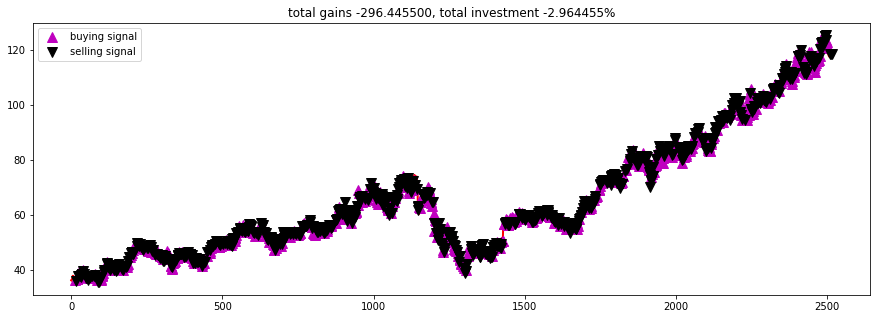

In [28]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = array['buy'])
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = array['sell'])
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

In [29]:
# Multiple execution 
NB_STOCKS = df_desc[df_desc['TYPE'] == 'Equity'].shape[0] 
invest = INVESTMENT // NB_STOCKS# slipt the amount invested
print(invest)
out  = [ agent.buy(initial_money = invest)
                    for isin in df_desc[df_desc['TYPE'] == 'Equity'].index ]

2500
day 13: buy 1 unit at price 36.500000, total balance 2463.500000
day 17, sell 1 unit at price 36.080000, investment -1.150685 %, total balance 2499.580000,
day 18: buy 1 unit at price 36.900000, total balance 2462.680000
day 19: buy 1 unit at price 36.940000, total balance 2425.740000
day 22: buy 1 unit at price 37.300000, total balance 2388.440000
day 23, sell 1 unit at price 37.920000, investment 2.764228 %, total balance 2426.360000,
day 26: buy 1 unit at price 39.410000, total balance 2386.950000
day 28, sell 1 unit at price 37.750000, investment 2.192745 %, total balance 2424.700000,
day 29: buy 1 unit at price 37.610000, total balance 2387.090000
day 30: buy 1 unit at price 37.760000, total balance 2349.330000
day 32, sell 1 unit at price 37.480000, investment 0.482574 %, total balance 2386.810000,
day 33, sell 1 unit at price 38.180000, investment -3.121035 %, total balance 2424.990000,
day 35: buy 1 unit at price 38.450000, total balance 2386.540000
day 36, sell 1 unit at 

day 628: buy 1 unit at price 57.130000, total balance 2158.807200
day 631, sell 1 unit at price 55.850000, investment 4.490178 %, total balance 2214.657200,
day 633, sell 1 unit at price 56.310000, investment 7.114324 %, total balance 2270.967200,
day 638, sell 1 unit at price 53.960000, investment 2.761379 %, total balance 2324.927200,
day 640: buy 1 unit at price 53.790000, total balance 2271.137200
day 641, sell 1 unit at price 53.350000, investment 1.988148 %, total balance 2324.487200,
day 642: buy 1 unit at price 52.560000, total balance 2271.927200
day 643, sell 1 unit at price 53.360000, investment -4.816268 %, total balance 2325.287200,
day 644: buy 1 unit at price 54.000000, total balance 2271.287200
day 646, sell 1 unit at price 51.450000, investment -9.942237 %, total balance 2322.737200,
day 648: buy 1 unit at price 52.760000, total balance 2269.977200
day 649, sell 1 unit at price 52.250000, investment -2.862986 %, total balance 2322.227200,
day 650: buy 1 unit at price 5

day 1294: buy 1 unit at price 42.550000, total balance 993.937100
day 1296: buy 1 unit at price 41.550000, total balance 952.387100
day 1299: buy 1 unit at price 40.690000, total balance 911.697100
day 1300, sell 1 unit at price 40.810000, investment -13.739167 %, total balance 952.507100,
day 1302, sell 1 unit at price 38.980000, investment -16.638152 %, total balance 991.487100,
day 1304: buy 1 unit at price 40.140000, total balance 951.347100
day 1305, sell 1 unit at price 39.560000, investment -23.139693 %, total balance 990.907100,
day 1307, sell 1 unit at price 42.200000, investment -20.000000 %, total balance 1033.107100,
day 1311: buy 1 unit at price 45.120000, total balance 987.987100
day 1315: buy 1 unit at price 46.810000, total balance 941.177100
day 1316: buy 1 unit at price 48.460000, total balance 892.717100
day 1317: buy 1 unit at price 47.400000, total balance 845.317100
day 1318: buy 1 unit at price 46.250000, total balance 799.067100
day 1322, sell 1 unit at price 48

day 1939, sell 1 unit at price 81.900000, investment 3.670886 %, total balance 691.604600,
day 1940: buy 1 unit at price 83.010000, total balance 608.594600
day 1941: buy 1 unit at price 84.240000, total balance 524.354600
day 1942, sell 1 unit at price 85.030000, investment 7.728367 %, total balance 609.384600,
day 1944: buy 1 unit at price 84.430000, total balance 524.954600
day 1945: buy 1 unit at price 83.185000, total balance 441.769600
day 1946, sell 1 unit at price 83.370000, investment 6.271511 %, total balance 525.139600,
day 1947, sell 1 unit at price 84.450000, investment 8.366483 %, total balance 609.589600,
day 1952: buy 1 unit at price 81.630000, total balance 527.959600
day 1956: buy 1 unit at price 79.020000, total balance 448.939600
day 1958: buy 1 unit at price 80.900000, total balance 368.039600
day 1959: buy 1 unit at price 81.420000, total balance 286.619600
day 1960, sell 1 unit at price 81.670000, investment 0.516923 %, total balance 368.289600,
day 1961: buy 1 u

day 13: buy 1 unit at price 36.500000, total balance 2463.500000
day 17, sell 1 unit at price 36.080000, investment -1.150685 %, total balance 2499.580000,
day 18: buy 1 unit at price 36.900000, total balance 2462.680000
day 19: buy 1 unit at price 36.940000, total balance 2425.740000
day 22: buy 1 unit at price 37.300000, total balance 2388.440000
day 23, sell 1 unit at price 37.920000, investment 2.764228 %, total balance 2426.360000,
day 26: buy 1 unit at price 39.410000, total balance 2386.950000
day 28, sell 1 unit at price 37.750000, investment 2.192745 %, total balance 2424.700000,
day 29: buy 1 unit at price 37.610000, total balance 2387.090000
day 30: buy 1 unit at price 37.760000, total balance 2349.330000
day 32, sell 1 unit at price 37.480000, investment 0.482574 %, total balance 2386.810000,
day 33, sell 1 unit at price 38.180000, investment -3.121035 %, total balance 2424.990000,
day 35: buy 1 unit at price 38.450000, total balance 2386.540000
day 36, sell 1 unit at price

day 486: buy 1 unit at price 49.080000, total balance 2322.122000
day 487, sell 1 unit at price 49.350000, investment -1.201201 %, total balance 2371.472000,
day 488: buy 1 unit at price 48.290000, total balance 2323.182000
day 489: buy 1 unit at price 48.550000, total balance 2274.632000
day 490: buy 1 unit at price 48.679900, total balance 2225.952100
day 492, sell 1 unit at price 49.220000, investment -0.243210 %, total balance 2275.172100,
day 494: buy 1 unit at price 48.750000, total balance 2226.422100
day 500, sell 1 unit at price 49.770000, investment 1.405868 %, total balance 2276.192100,
day 503, sell 1 unit at price 49.470000, investment 2.443570 %, total balance 2325.662100,
day 504: buy 1 unit at price 49.920000, total balance 2275.742100
day 506: buy 1 unit at price 49.780000, total balance 2225.962100
day 507, sell 1 unit at price 49.850000, investment 2.677652 %, total balance 2275.812100,
day 509: buy 1 unit at price 50.000000, total balance 2225.812100
day 512: buy 1 

day 1098: buy 1 unit at price 74.220000, total balance 1901.067100
day 1100, sell 1 unit at price 73.270000, investment 6.979121 %, total balance 1974.337100,
day 1101, sell 1 unit at price 72.110000, investment 4.340906 %, total balance 2046.447100,
day 1104, sell 1 unit at price 70.760000, investment 3.936545 %, total balance 2117.207100,
day 1105, sell 1 unit at price 71.320000, investment 0.691797 %, total balance 2188.527100,
day 1106: buy 1 unit at price 72.590000, total balance 2115.937100
day 1107, sell 1 unit at price 73.240000, investment 1.524813 %, total balance 2189.177100,
day 1108: buy 1 unit at price 72.980000, total balance 2116.197100
day 1109: buy 1 unit at price 71.320000, total balance 2044.877100
day 1110: buy 1 unit at price 70.330000, total balance 1974.547100
day 1111, sell 1 unit at price 70.040000, investment -1.629213 %, total balance 2044.587100,
day 1112, sell 1 unit at price 70.810000, investment -0.881859 %, total balance 2115.397100,
day 1113, sell 1 un

day 1688, sell 1 unit at price 61.240000, investment 5.622628 %, total balance 821.334600,
day 1691, sell 1 unit at price 61.270000, investment 5.765579 %, total balance 882.604600,
day 1692: buy 1 unit at price 62.330000, total balance 820.274600
day 1693, sell 1 unit at price 62.500000, investment 11.264409 %, total balance 882.774600,
day 1694: buy 1 unit at price 64.050000, total balance 818.724600
day 1695, sell 1 unit at price 63.730000, investment 11.027875 %, total balance 882.454600,
day 1696, sell 1 unit at price 65.000000, investment 12.749350 %, total balance 947.454600,
day 1697: buy 1 unit at price 64.670000, total balance 882.784600
day 1698: buy 1 unit at price 64.490000, total balance 818.294600
day 1699: buy 1 unit at price 65.050000, total balance 753.244600
day 1700: buy 1 unit at price 64.560000, total balance 688.684600
day 1701: buy 1 unit at price 64.660000, total balance 624.024600
day 1702: buy 1 unit at price 65.410000, total balance 558.614600
day 1703: buy 

day 2206: buy 1 unit at price 101.480000, total balance 866.377600
day 2207: buy 1 unit at price 101.790000, total balance 764.587600
day 2208, sell 1 unit at price 101.350000, investment 21.420870 %, total balance 865.937600,
day 2210, sell 1 unit at price 101.558000, investment 17.218375 %, total balance 967.495600,
day 2211: buy 1 unit at price 98.325000, total balance 869.170600
day 2212, sell 1 unit at price 97.550000, investment 10.688755 %, total balance 966.720600,
day 2213: buy 1 unit at price 96.510000, total balance 870.210600
day 2215: buy 1 unit at price 96.780000, total balance 773.430600
day 2216, sell 1 unit at price 96.330000, investment 8.553076 %, total balance 869.760600,
day 2217: buy 1 unit at price 94.780000, total balance 774.980600
day 2219, sell 1 unit at price 95.180000, investment 4.673925 %, total balance 870.160600,
day 2226: buy 1 unit at price 97.730000, total balance 772.430600
day 2227: buy 1 unit at price 98.790000, total balance 673.640600
day 2228: 

day 217, sell 1 unit at price 48.690000, investment 5.366804 %, total balance 2179.037000,
day 218: buy 1 unit at price 49.120000, total balance 2129.917000
day 219, sell 1 unit at price 49.740000, investment 5.403687 %, total balance 2179.657000,
day 220: buy 1 unit at price 48.630000, total balance 2131.027000
day 222: buy 1 unit at price 48.350000, total balance 2082.677000
day 224, sell 1 unit at price 48.900000, investment 1.578729 %, total balance 2131.577000,
day 225: buy 1 unit at price 49.690000, total balance 2081.887000
day 226: buy 1 unit at price 49.590000, total balance 2032.297000
day 228, sell 1 unit at price 49.430000, investment 0.020235 %, total balance 2081.727000,
day 229, sell 1 unit at price 48.600000, investment -1.917255 %, total balance 2130.327000,
day 230: buy 1 unit at price 49.625000, total balance 2080.702000
day 233: buy 1 unit at price 48.280000, total balance 2032.422000
day 235, sell 1 unit at price 48.900000, investment -0.569337 %, total balance 208

day 692: buy 1 unit at price 48.750000, total balance 2227.437200
day 694: buy 1 unit at price 50.320000, total balance 2177.117200
day 695, sell 1 unit at price 50.360000, investment -0.983091 %, total balance 2227.477200,
day 696, sell 1 unit at price 49.480000, investment -1.551930 %, total balance 2276.957200,
day 697: buy 1 unit at price 49.810000, total balance 2227.147200
day 700, sell 1 unit at price 53.900000, investment 4.416893 %, total balance 2281.047200,
day 702, sell 1 unit at price 52.980000, investment 4.662189 %, total balance 2334.027200,
day 703: buy 1 unit at price 52.470000, total balance 2281.557200
day 704: buy 1 unit at price 52.140000, total balance 2229.417200
day 705, sell 1 unit at price 51.660000, investment 5.969231 %, total balance 2281.077200,
day 706, sell 1 unit at price 51.690000, investment 2.722576 %, total balance 2332.767200,
day 707, sell 1 unit at price 52.690000, investment 5.781971 %, total balance 2385.457200,
day 709: buy 1 unit at price 52

day 1261: buy 1 unit at price 51.450000, total balance 1395.817100
day 1262: buy 1 unit at price 50.120000, total balance 1345.697100
day 1263, sell 1 unit at price 50.650000, investment -12.355079 %, total balance 1396.347100,
day 1264, sell 1 unit at price 49.140000, investment -15.246637 %, total balance 1445.487100,
day 1266: buy 1 unit at price 48.940000, total balance 1396.547100
day 1267: buy 1 unit at price 47.630000, total balance 1348.917100
day 1269, sell 1 unit at price 48.800000, investment -6.531316 %, total balance 1397.717100,
day 1270: buy 1 unit at price 47.220000, total balance 1350.497100
day 1271: buy 1 unit at price 47.900000, total balance 1302.597100
day 1272, sell 1 unit at price 47.450000, investment -8.574181 %, total balance 1350.047100,
day 1273: buy 1 unit at price 46.970000, total balance 1303.077100
day 1274: buy 1 unit at price 47.350000, total balance 1255.727100
day 1275: buy 1 unit at price 47.900000, total balance 1207.827100
day 1277, sell 1 unit a

day 1789, sell 1 unit at price 74.670000, investment 15.785393 %, total balance 829.584600,
day 1790: buy 1 unit at price 74.550000, total balance 755.034600
day 1791: buy 1 unit at price 75.040000, total balance 679.994600
day 1792, sell 1 unit at price 74.660000, investment 14.773251 %, total balance 754.654600,
day 1793, sell 1 unit at price 74.330000, investment 15.133209 %, total balance 828.984600,
day 1794, sell 1 unit at price 74.960000, investment 15.929477 %, total balance 903.944600,
day 1800: buy 1 unit at price 73.570000, total balance 830.374600
day 1801, sell 1 unit at price 74.790000, investment 14.340315 %, total balance 905.164600,
day 1802, sell 1 unit at price 73.620000, investment 12.810297 %, total balance 978.784600,
day 1803, sell 1 unit at price 71.760000, investment 11.567164 %, total balance 1050.544600,
day 1804: buy 1 unit at price 72.490000, total balance 978.054600
day 1805, sell 1 unit at price 72.810000, investment 14.951058 %, total balance 1050.864600

day 2353, sell 1 unit at price 109.140000, investment 3.012507 %, total balance 398.842400,
day 2356, sell 1 unit at price 111.390000, investment 12.572006 %, total balance 510.232400,
day 2357: buy 1 unit at price 112.820000, total balance 397.412400
day 2359, sell 1 unit at price 113.050000, investment 15.534925 %, total balance 510.462400,
day 2360, sell 1 unit at price 112.020000, investment 15.583080 %, total balance 622.482400,
day 2361, sell 1 unit at price 113.480000, investment 14.061715 %, total balance 735.962400,
day 2362: buy 1 unit at price 113.380000, total balance 622.582400
day 2364, sell 1 unit at price 114.390000, investment 15.861440 %, total balance 736.972400,
day 2365: buy 1 unit at price 114.830000, total balance 622.142400
day 2367, sell 1 unit at price 111.880000, investment 10.367959 %, total balance 734.022400,
day 2368: buy 1 unit at price 109.631000, total balance 624.391400
day 2370, sell 1 unit at price 110.660000, investment 9.315420 %, total balance 73

day 415: buy 1 unit at price 43.410000, total balance 2120.082000
day 416, sell 1 unit at price 43.120000, investment -7.328605 %, total balance 2163.202000,
day 417, sell 1 unit at price 43.410000, investment -2.339708 %, total balance 2206.612000,
day 418, sell 1 unit at price 43.040000, investment -0.600462 %, total balance 2249.652000,
day 420, sell 1 unit at price 43.180000, investment 0.911428 %, total balance 2292.832000,
day 421, sell 1 unit at price 43.160000, investment -2.419173 %, total balance 2335.992000,
day 422: buy 1 unit at price 43.200000, total balance 2292.792000
day 423, sell 1 unit at price 43.310000, investment -0.778923 %, total balance 2336.102000,
day 425, sell 1 unit at price 43.040000, investment -0.669282 %, total balance 2379.142000,
day 426, sell 1 unit at price 43.920000, investment 1.174845 %, total balance 2423.062000,
day 427: buy 1 unit at price 43.530000, total balance 2379.532000
day 428: buy 1 unit at price 43.160000, total balance 2336.372000
da

day 1094: buy 1 unit at price 71.200000, total balance 2120.407100
day 1095: buy 1 unit at price 71.440000, total balance 2048.967100
day 1096: buy 1 unit at price 73.680000, total balance 1975.287100
day 1098: buy 1 unit at price 74.220000, total balance 1901.067100
day 1100, sell 1 unit at price 73.270000, investment 6.979121 %, total balance 1974.337100,
day 1101, sell 1 unit at price 72.110000, investment 4.340906 %, total balance 2046.447100,
day 1104, sell 1 unit at price 70.760000, investment 3.936545 %, total balance 2117.207100,
day 1105, sell 1 unit at price 71.320000, investment 0.691797 %, total balance 2188.527100,
day 1106: buy 1 unit at price 72.590000, total balance 2115.937100
day 1107, sell 1 unit at price 73.240000, investment 1.524813 %, total balance 2189.177100,
day 1108: buy 1 unit at price 72.980000, total balance 2116.197100
day 1109: buy 1 unit at price 71.320000, total balance 2044.877100
day 1110: buy 1 unit at price 70.330000, total balance 1974.547100
day 

day 1599: buy 1 unit at price 57.940000, total balance 876.577100
day 1600: buy 1 unit at price 57.880000, total balance 818.697100
day 1601, sell 1 unit at price 57.670000, investment 0.260779 %, total balance 876.367100,
day 1604: buy 1 unit at price 57.780000, total balance 818.587100
day 1607, sell 1 unit at price 57.440000, investment -0.845848 %, total balance 876.027100,
day 1608, sell 1 unit at price 56.760000, investment -4.040575 %, total balance 932.787100,
day 1609, sell 1 unit at price 56.500000, investment -4.689609 %, total balance 989.287100,
day 1611: buy 1 unit at price 58.740000, total balance 930.547100
day 1613: buy 1 unit at price 57.980000, total balance 872.567100
day 1614, sell 1 unit at price 58.950000, investment -2.835009 %, total balance 931.517100,
day 1615: buy 1 unit at price 57.930000, total balance 873.587100
day 1616: buy 1 unit at price 56.172500, total balance 817.414600
day 1618, sell 1 unit at price 56.660000, investment -6.362585 %, total balance

day 1985, sell 1 unit at price 81.980000, investment 1.775295 %, total balance 123.379600,
day 1987: buy 1 unit at price 81.290000, total balance 42.089600
day 1991, sell 1 unit at price 82.230000, investment 5.086262 %, total balance 124.319600,
day 1996: buy 1 unit at price 87.200000, total balance 37.119600
day 1997, sell 1 unit at price 88.060000, investment 13.326041 %, total balance 125.179600,
day 1998, sell 1 unit at price 87.470000, investment 13.479502 %, total balance 212.649600,
day 1999: buy 1 unit at price 85.760000, total balance 126.889600
day 2002: buy 1 unit at price 83.630000, total balance 43.259600
day 2008, sell 1 unit at price 83.790000, investment 9.515096 %, total balance 127.049600,
day 2009, sell 1 unit at price 83.770000, investment 9.160803 %, total balance 210.819600,
day 2010, sell 1 unit at price 84.660000, investment 14.281857 %, total balance 295.479600,
day 2012, sell 1 unit at price 84.180000, investment 12.038331 %, total balance 379.659600,
day 201